#### This notebook demonstrates the use of the Reject Option Classification (ROC) post-processing algorithm for bias mitigation.
- The debiasing function used is implemented in the `RejectOptionClassification` class.
- Divide the dataset into training, validation, and testing partitions.
- Train classifier on original training data.
- Estimate the optimal classification threshold, that maximizes balanced accuracy without fairness constraints.
- Estimate the optimal classification threshold, and the critical region boundary (ROC margin) using a validation set for the desired constraint on fairness. The best parameters are those that maximize the classification threshold while satisfying the fairness constraints.
- The constraints can be used on the following fairness measures:
    * Statistical parity difference on the predictions of the classifier
    * Average odds difference for the classifier
    * Equal opportunity difference for the classifier
- Determine the prediction scores for testing data. Using the estimated optimal classification threshold, compute accuracy and fairness metrics.
- Using the determined optimal classification threshold and the ROC margin, adjust the predictions. Report accuracy and fairness metric on the new predictions.

In [1]:
%matplotlib inline
# Load all necessary packages
import sys
# sys.path.append("../")
sys.path.insert(0, '/home/jl0274/AIF360')
import numpy as np
from tqdm import tqdm
from warnings import warn

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult
from aif360.algorithms.postprocessing.reject_option_classification\
        import RejectOptionClassification
from common_utils import compute_metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [2]:
import aif360
aif360.__file__

'/home/jl0274/AIF360/aif360/__init__.py'

#### Load dataset and specify options

In [3]:
## import dataset
dataset_used = "adult" # "adult", "german", "compas"
protected_attribute_used = 1 # 1, 2

if dataset_used == "adult":
#     dataset_orig = AdultDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_adult(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_adult(['race'])
    
elif dataset_used == "german":
#     dataset_orig = GermanDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_german(['sex'])
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        dataset_orig = load_preproc_data_german(['age'])
    
elif dataset_used == "compas":
#     dataset_orig = CompasDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_compas(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]  
        dataset_orig = load_preproc_data_compas(['race'])

        
# Metric used (should be one of allowed_metrics)
metric_name = "Statistical parity difference"

# Upper and lower bound on the fairness metric used
metric_ub = 0.05
metric_lb = -0.05
        
#random seed for calibrated equal odds prediction
np.random.seed(1)

# Verify metric name
allowed_metrics = ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]
if metric_name not in allowed_metrics:
    raise ValueError("Metric name should be one of allowed metrics")

standard dataset: is na? False


#### Split into train, test and validation

In [4]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

#### Clean up training data and display properties of the data

In [5]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(827046, 21)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([0.])] [array([1.])]


#### Dataset feature names

['hoepa_status_2.0', 'hoepa_status_3.0', 'total_loan_costs', 'rate_spread', 'interest_rate', 'origination_charges', 'lender_credits', 'derived_dwelling_category_Single Family (1-4 Units):Site-Built', 'loan_term', 'discount_points', 'construction_method_2.0', 'tract_to_msa_income_percentage', 'combined_loan_to_value_ratio', 'tract_population', 'tract_minority_population_percent', 'property_value', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes', 'purchaser_type_1.0', 'income', 'sex']


#### Metric for original training data

In [6]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.053654


## Gender Present

### Train classifier on original data

In [5]:
# Logistic regression classifier and predictions
X_train = dataset_orig_train.features
y_train = dataset_orig_train.labels.ravel()

rf = RandomForestClassifier(n_estimators=550, max_features='sqrt', max_depth=None, min_samples_split=10, min_samples_leaf=1, bootstrap = True)
rf.fit(X_train, y_train,
            sample_weight=dataset_orig_train.instance_weights)
y_train_pred = rf.predict(X_train)

# positive class index
pos_ind = np.where(rf.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)
dataset_orig_train_pred.labels = y_train_pred

#### Obtain scores for validation and test sets

In [6]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = dataset_orig_valid_pred.features
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = rf.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = dataset_orig_test_pred.features
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = rf.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

### Find the optimal parameters from the validation set

#### Best threshold for classification only (no fairness)

In [9]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no fairness constraints) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no fairness constraints) = %.4f" % best_class_thresh)

Best balanced accuracy (no fairness constraints) = 0.9916
Optimal classification threshold (no fairness constraints) = 0.5940


#### Estimate optimal parameters for the ROC method

In [10]:
ROC = RejectOptionClassification(unprivileged_groups=unprivileged_groups, 
                                 privileged_groups=privileged_groups, 
                                 low_class_thresh=0.01, high_class_thresh=0.99,
                                  num_class_thresh=100, num_ROC_margin=50,
                                  metric_name=metric_name,
                                  metric_ub=metric_ub, metric_lb=metric_lb)
ROC = ROC.fit(dataset_orig_valid, dataset_orig_valid_pred)

In [11]:
print("Optimal classification threshold (with fairness constraints) = %.4f" % ROC.classification_threshold)
print("Optimal ROC margin = %.4f" % ROC.ROC_margin)

Optimal classification threshold (with fairness constraints) = 0.5940
Optimal ROC margin = 0.0000


### Predictions from Validation Set

In [12]:
# Metrics for the test set
fav_inds = dataset_orig_valid_pred.scores > best_class_thresh
dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label

display(Markdown("#### Validation set"))
display(Markdown("##### Raw predictions - No fairness constraints, only maximizing balanced accuracy"))

metric_valid_bef = compute_metrics(dataset_orig_valid, dataset_orig_valid_pred, 
                unprivileged_groups, privileged_groups)

#### Validation set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Balanced accuracy = 0.9916
Statistical parity difference = 0.0496
Disparate impact = 1.0695
Average odds difference = -0.0001
Equal opportunity difference = -0.0023
Theil index = 0.0099


In [13]:
# Transform the validation set
dataset_transf_valid_pred = ROC.predict(dataset_orig_valid_pred)

display(Markdown("#### Validation set"))
display(Markdown("##### Transformed predictions - With fairness constraints"))
metric_valid_aft = compute_metrics(dataset_orig_valid, dataset_transf_valid_pred, 
                unprivileged_groups, privileged_groups)

#### Validation set

##### Transformed predictions - With fairness constraints

Balanced accuracy = 0.9916
Statistical parity difference = 0.0496
Disparate impact = 1.0695
Average odds difference = -0.0001
Equal opportunity difference = -0.0023
Theil index = 0.0099


In [14]:
# Testing: Check if the metric optimized has not become worse
# assert np.abs(metric_valid_aft[metric_name]) <= np.abs(metric_valid_bef[metric_name])

### Predictions from Original Test Set

In [15]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []
spd_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])
    spd_diff_arr_orig.append(metric_test_bef["Statistical parity difference"])

#### Predictions from original testing data

Classification threshold used = 0.5940


 62%|██████▏   | 62/100 [00:04<00:02, 14.55it/s]

Balanced accuracy = 0.9919
Statistical parity difference = 0.0490
Disparate impact = 1.0685
Average odds difference = -0.0002
Equal opportunity difference = -0.0026
Theil index = 0.0097


100%|██████████| 100/100 [00:06<00:00, 14.50it/s]


In [16]:
# inputs should be y_test, dataset_orig_test_pred.labels, dataset_orig_test_pred.scores respectively 
def accuracy_scores(y_true, preds, y_pred_scores, best_class_thresh):
    # F1 score
    y_pred = (y_pred_scores > best_class_thresh).astype(int)
    y_pred[y_pred == 1] = preds.favorable_label
    y_pred[y_pred == 0] = preds.unfavorable_label
    f1 = f1_score(y_true, y_pred)
    print(f"F1 Score: {f1:.4f}")
    # AUC
    auc = roc_auc_score(y_true, dataset_orig_test_pred.scores)
    print(f"ROC AUC Score: {auc:.4f}")
    
    return f1, auc
    
f1, auc = accuracy_scores(dataset_orig_test.labels, dataset_orig_test_pred, dataset_orig_test_pred.scores, best_class_thresh)

F1 Score: 0.9932
ROC AUC Score: 0.9995


In [17]:
# bias summary metrics
def bias_summary_metrics(gender_col, target):
    # test whether loan approval significantly depends on gender
    gender_col = pd.Series(gender_col)  # Convert gender to categorical
    target = pd.Series(target.ravel())

    # Create a contingency table
    contingency_table = pd.crosstab(gender_col, target)
    
    # Perform the Chi-Square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"Chi-Square Statistic: {chi2}")
    print(f"P-value: {p_value}")
    
    if p_value < 0.05:
        print("There is a significant association between gender and loan approval.")
    else:
        print("There is no significant association between gender and loan approval.")

    # test whether there's a significant difference in loan approval proportions across men vs women

    # Count of approvals for men and women
    men_approved = sum((gender_col == 0) & (target == 1))
    women_approved = sum((gender_col == 1) & (target == 1))
    
    # Total number of applicants in each group
    men_total = sum(gender_col == 0)
    women_total = sum(gender_col == 1)
    
    # Run the Z-test
    count = [men_approved, women_approved]
    nobs = [men_total, women_total]
    stat, p_value = proportions_ztest(count, nobs)
    
    print(f"Z-statistic: {stat}")
    print(f"P-value: {p_value:10e}")
    
    if p_value < 0.05:
        print("There is a significant difference in loan approval rates between men and women.")
    else:
        print("There is no significant difference in loan approval rates between men and women.")

    men_approved_prop = men_approved/men_total
    women_approved_prop = women_approved/women_total
    print(f'male approval rate: {men_approved_prop}')
    print(f'female approval rate: {women_approved_prop}')
    

In [18]:
bias_summary_metrics(X_test[:, -1], dataset_orig_test_pred.labels)

Chi-Square Statistic: 412.63761787951364
P-value: 9.772129979545818e-92
There is a significant association between gender and loan approval.
Z-statistic: 20.319086499593713
P-value: 8.718357e-92
There is a significant difference in loan approval rates between men and women.
male approval rate: 0.743819971773181
female approval rate: 0.6987461932223158


In [19]:
# Metrics for the test set
fav_inds = dataset_orig_test_pred.scores > best_class_thresh
dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label

display(Markdown("#### Test set"))
display(Markdown("##### Raw predictions - No fairness constraints, only maximizing balanced accuracy"))

metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                unprivileged_groups, privileged_groups)

#### Test set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Balanced accuracy = 0.9919
Statistical parity difference = 0.0490
Disparate impact = 1.0685
Average odds difference = -0.0002
Equal opportunity difference = -0.0026
Theil index = 0.0097


### Graph Original Test Set

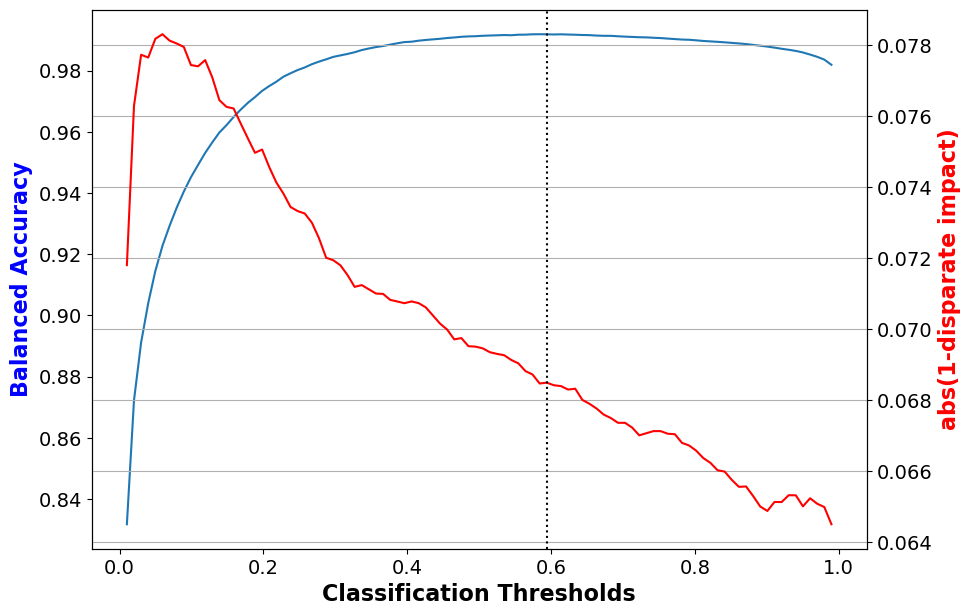

In [20]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig("reject-xg-di-orig-gen")

plt.show()

```abs(1-disparate impact)``` must be small (close to 0) for classifier predictions to be fair.

However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

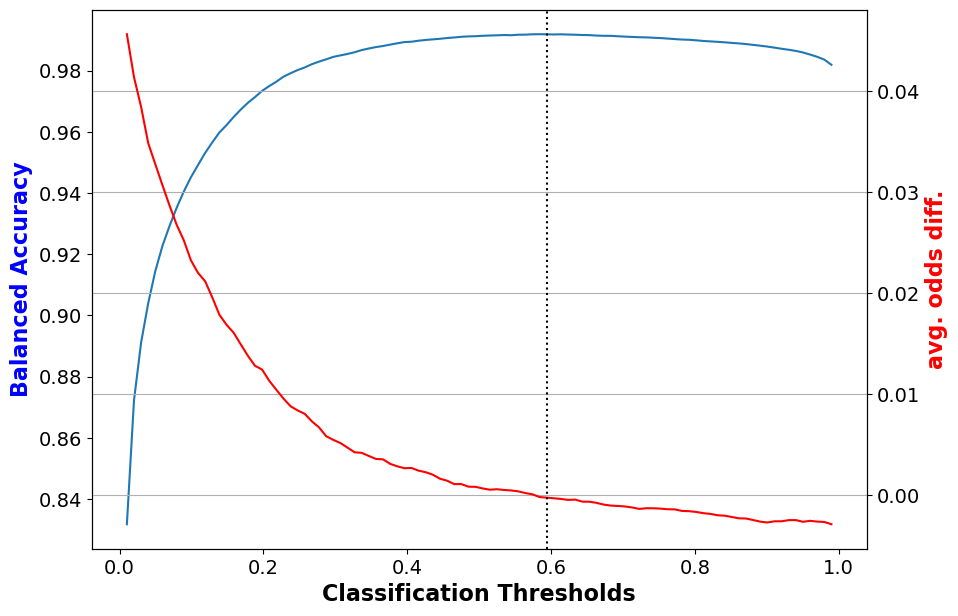

In [21]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig("reject-xg-aodds-orig-gen")

plt.show()

### Predictions from Transformed Test Set

In [22]:
# Metrics for the transformed test set
dataset_transf_test_pred = ROC.predict(dataset_orig_test_pred)

display(Markdown("#### Test set"))
display(Markdown("##### Transformed predictions - With fairness constraints"))
metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                unprivileged_groups, privileged_groups)

#### Test set

##### Transformed predictions - With fairness constraints

Balanced accuracy = 0.9919
Statistical parity difference = 0.0490
Disparate impact = 1.0685
Average odds difference = -0.0002
Equal opportunity difference = -0.0026
Theil index = 0.0097


In [23]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []
spd_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])
    spd_diff_arr_transf.append(metric_test_bef["Statistical parity difference"])

#### Predictions from transformed testing data

Classification threshold used = 0.5940


 62%|██████▏   | 62/100 [00:04<00:02, 14.71it/s]

Balanced accuracy = 0.9919
Statistical parity difference = 0.0490
Disparate impact = 1.0685
Average odds difference = -0.0002
Equal opportunity difference = -0.0026
Theil index = 0.0097


100%|██████████| 100/100 [00:06<00:00, 14.60it/s]


In [24]:
f1, auc = accuracy_scores(dataset_orig_test.labels, dataset_transf_test_pred, dataset_transf_test_pred.scores, ROC.classification_threshold)

F1 Score: 0.9932
ROC AUC Score: 0.9995


In [25]:
bias_summary_metrics(X_test[:, -1], dataset_transf_test_pred.labels)

Chi-Square Statistic: 412.63761787951364
P-value: 9.772129979545818e-92
There is a significant association between gender and loan approval.
Z-statistic: 20.319086499593713
P-value: 8.718357e-92
There is a significant difference in loan approval rates between men and women.
male approval rate: 0.743819971773181
female approval rate: 0.6987461932223158


### Graph Transformed Test Set

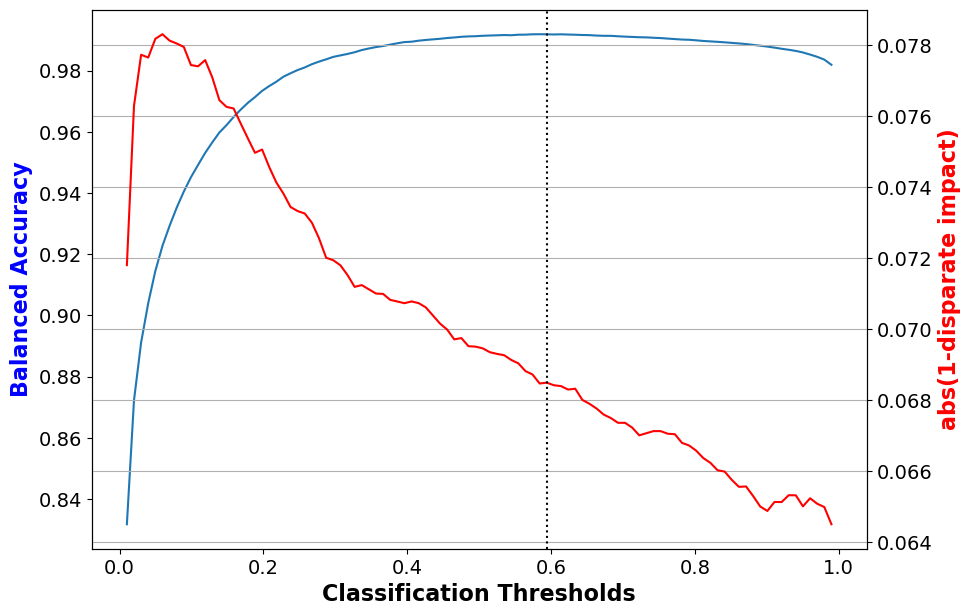

In [26]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig("reject-xg-di-transf-gen")

plt.show()

```abs(1-disparate impact)``` must be small (close to 0) for classifier predictions to be fair.

For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case.
This implies fairness.

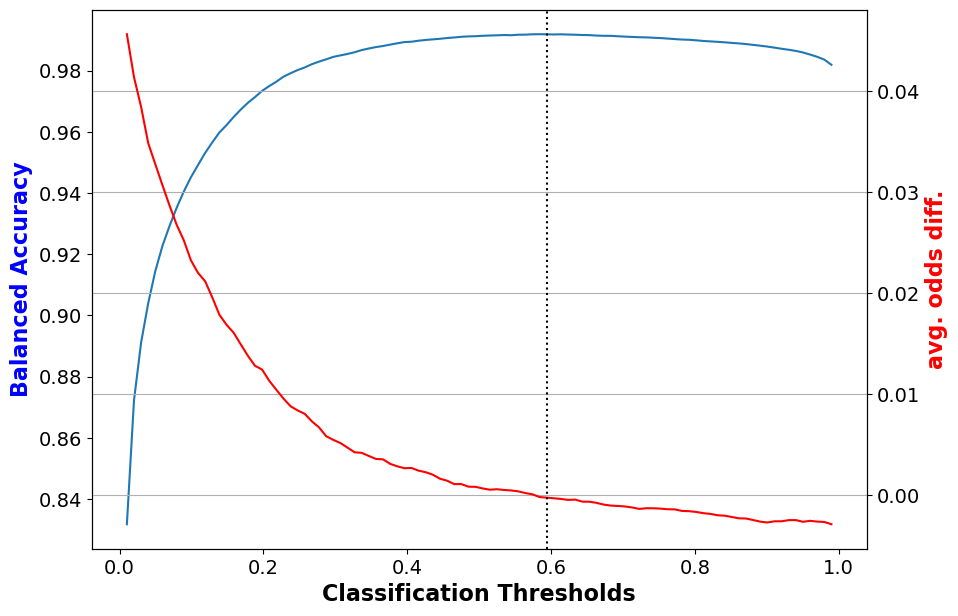

In [27]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig("reject-xg-aodds-transf-gen")

plt.show()

## Gender Not Present

In [7]:
gender_col = X_test[:, -1]

In [8]:
# inputs should be y_test, dataset_orig_test_pred.labels, dataset_orig_test_pred.scores respectively 
def accuracy_scores(y_true, preds, y_pred_scores, best_class_thresh):
    # F1 score
    y_pred = (y_pred_scores > best_class_thresh).astype(int)
    y_pred[y_pred == 1] = preds.favorable_label
    y_pred[y_pred == 0] = preds.unfavorable_label
    f1 = f1_score(y_true, y_pred)
    print(f"F1 Score: {f1:.4f}")
    # AUC
    auc = roc_auc_score(y_true, dataset_orig_test_pred.scores)
    print(f"ROC AUC Score: {auc:.4f}")
    
    return f1, auc

### Train classifier on original data

In [9]:
# Logistic regression classifier and predictions
X_train = dataset_orig_train.features[:, :-1]
y_train = dataset_orig_train.labels.ravel()

rf = RandomForestClassifier(n_estimators=550, max_features='sqrt', max_depth=None, min_samples_split=10, min_samples_leaf=1, bootstrap = True)
rf.fit(X_train, y_train,
            sample_weight=dataset_orig_train.instance_weights)
y_train_pred = rf.predict(X_train)

# positive class index
pos_ind = np.where(rf.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)
dataset_orig_train_pred.labels = y_train_pred

#### Obtain scores for validation and test sets

In [10]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = dataset_orig_valid_pred.features[:, :-1]
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = rf.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = dataset_orig_test_pred.features[:, :-1]
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = rf.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

### Find the optimal parameters from the validation set

#### Best threshold for classification only (no fairness)

In [11]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no fairness constraints) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no fairness constraints) = %.4f" % best_class_thresh)

Best balanced accuracy (no fairness constraints) = 0.9916
Optimal classification threshold (no fairness constraints) = 0.5940


#### Estimate optimal parameters for the ROC method

In [12]:
ROC = RejectOptionClassification(unprivileged_groups=unprivileged_groups, 
                                 privileged_groups=privileged_groups, 
                                 low_class_thresh=0.01, high_class_thresh=0.99,
                                  num_class_thresh=100, num_ROC_margin=50,
                                  metric_name=metric_name,
                                  metric_ub=metric_ub, metric_lb=metric_lb)
ROC = ROC.fit(dataset_orig_valid, dataset_orig_valid_pred)

In [13]:
print("Optimal classification threshold (with fairness constraints) = %.4f" % ROC.classification_threshold)
print("Optimal ROC margin = %.4f" % ROC.ROC_margin)

Optimal classification threshold (with fairness constraints) = 0.5841
Optimal ROC margin = 0.0085


### Predictions from Validation Set

In [14]:
# Metrics for the test set
fav_inds = dataset_orig_valid_pred.scores > best_class_thresh
dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label

display(Markdown("#### Validation set"))
display(Markdown("##### Raw predictions - No fairness constraints, only maximizing balanced accuracy"))

metric_valid_bef = compute_metrics(dataset_orig_valid, dataset_orig_valid_pred, 
                unprivileged_groups, privileged_groups)

#### Validation set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Balanced accuracy = 0.9916
Statistical parity difference = 0.0490
Disparate impact = 1.0685
Average odds difference = -0.0006
Equal opportunity difference = -0.0031
Theil index = 0.0097


In [15]:
# Transform the validation set
dataset_transf_valid_pred = ROC.predict(dataset_orig_valid_pred)

display(Markdown("#### Validation set"))
display(Markdown("##### Transformed predictions - With fairness constraints"))
metric_valid_aft = compute_metrics(dataset_orig_valid, dataset_transf_valid_pred, 
                unprivileged_groups, privileged_groups)

#### Validation set

##### Transformed predictions - With fairness constraints

Balanced accuracy = 0.9916
Statistical parity difference = 0.0496
Disparate impact = 1.0693
Average odds difference = -0.0000
Equal opportunity difference = -0.0025
Theil index = 0.0094


In [16]:
# Testing: Check if the metric optimized has not become worse
# assert np.abs(metric_valid_aft[metric_name]) <= np.abs(metric_valid_bef[metric_name])

### Predictions from Original Test Set

In [17]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []
spd_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])
    spd_diff_arr_orig.append(metric_test_bef["Statistical parity difference"])

#### Predictions from original testing data

Classification threshold used = 0.5940


 62%|██████▏   | 62/100 [00:04<00:02, 14.66it/s]

Balanced accuracy = 0.9919
Statistical parity difference = 0.0483
Disparate impact = 1.0675
Average odds difference = -0.0007
Equal opportunity difference = -0.0034
Theil index = 0.0095


100%|██████████| 100/100 [00:06<00:00, 14.60it/s]


In [18]:
# inputs should be y_test, dataset_orig_test_pred.labels, dataset_orig_test_pred.scores respectively 
def accuracy_scores(y_true, preds, y_pred_scores, best_class_thresh):
    # F1 score
    y_pred = (y_pred_scores > best_class_thresh).astype(int)
    y_pred[y_pred == 1] = preds.favorable_label
    y_pred[y_pred == 0] = preds.unfavorable_label
    f1 = f1_score(y_true, y_pred)
    print(f"F1 Score: {f1:.4f}")
    # AUC
    auc = roc_auc_score(y_true, dataset_orig_test_pred.scores)
    print(f"ROC AUC Score: {auc:.4f}")
    
    return f1, auc

In [19]:
f1, auc = accuracy_scores(dataset_orig_test.labels, dataset_orig_test_pred, dataset_orig_test_pred.scores, best_class_thresh)

F1 Score: 0.9933
ROC AUC Score: 0.9995


In [20]:
# bias summary metrics
def bias_summary_metrics(gender_col, target):
    # test whether loan approval significantly depends on gender
    gender_col = pd.Series(gender_col)  # Convert gender to categorical
    target = pd.Series(target.ravel())
    print('target:', target)

    # Create a contingency table
    contingency_table = pd.crosstab(gender_col, target)
    
    # Perform the Chi-Square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"Chi-Square Statistic: {chi2}")
    print(f"P-value: {p_value}")
    
    if p_value < 0.05:
        print("There is a significant association between gender and loan approval.")
    else:
        print("There is no significant association between gender and loan approval.")

    # test whether there's a significant difference in loan approval proportions across men vs women

    # Count of approvals for men and women
    men_approved = sum((gender_col == 0) & (target == 1))
    women_approved = sum((gender_col == 1) & (target == 1))
    
    # Total number of applicants in each group
    men_total = sum(gender_col == 0)
    women_total = sum(gender_col == 1)
    
    # Run the Z-test
    count = [men_approved, women_approved]
    nobs = [men_total, women_total]
    stat, p_value = proportions_ztest(count, nobs)
    
    print(f"Z-statistic: {stat}")
    print(f"P-value: {p_value:10e}")
    
    if p_value < 0.05:
        print("There is a significant difference in loan approval rates between men and women.")
    else:
        print("There is no significant difference in loan approval rates between men and women.")

    print('men total:', men_total)
    print('women total:', women_total)
    men_approved_prop = men_approved/men_total
    women_approved_prop = women_approved/women_total
    print(f'male approval rate: {men_approved_prop}')
    print(f'female approval rate: {women_approved_prop}')

bias_summary_metrics(gender_col, dataset_orig_test_pred.labels)

target: 0         1.0
1         0.0
2         1.0
3         1.0
4         1.0
         ... 
177220    0.0
177221    0.0
177222    1.0
177223    1.0
177224    1.0
Length: 177225, dtype: float64
Chi-Square Statistic: 411.46091752396467
P-value: 1.7624776169240157e-91
There is a significant association between gender and loan approval.
Z-statistic: 20.290106492543153
P-value: 1.572542e-91
There is a significant difference in loan approval rates between men and women.
men total: 115493
women total: 61732
male approval rate: 0.7444347276458313
female approval rate: 0.6994589515972267


In [21]:
gender_col

array([1., 1., 0., ..., 0., 0., 0.])

In [22]:
dataset_orig_test_pred.labels

array([[1.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [23]:
# Metrics for the test set
fav_inds = dataset_orig_test_pred.scores > best_class_thresh
dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label

display(Markdown("#### Test set"))
display(Markdown("##### Raw predictions - No fairness constraints, only maximizing balanced accuracy"))

metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                unprivileged_groups, privileged_groups)

#### Test set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Balanced accuracy = 0.9919
Statistical parity difference = 0.0483
Disparate impact = 1.0675
Average odds difference = -0.0007
Equal opportunity difference = -0.0034
Theil index = 0.0095


### Graph Original Test Set

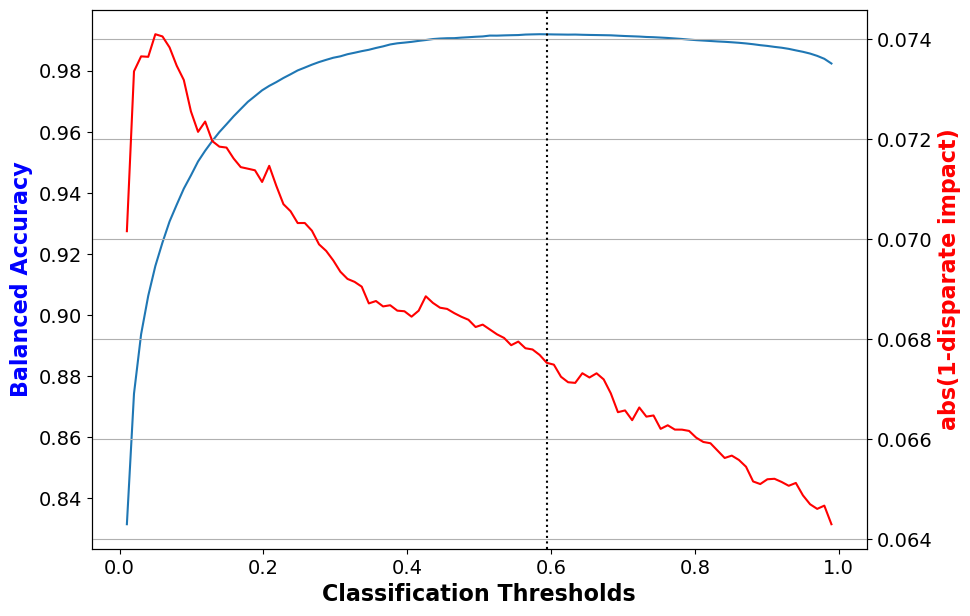

In [24]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig("reject-xg-di-orig-nogen")

plt.show()

```abs(1-disparate impact)``` must be small (close to 0) for classifier predictions to be fair.

However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

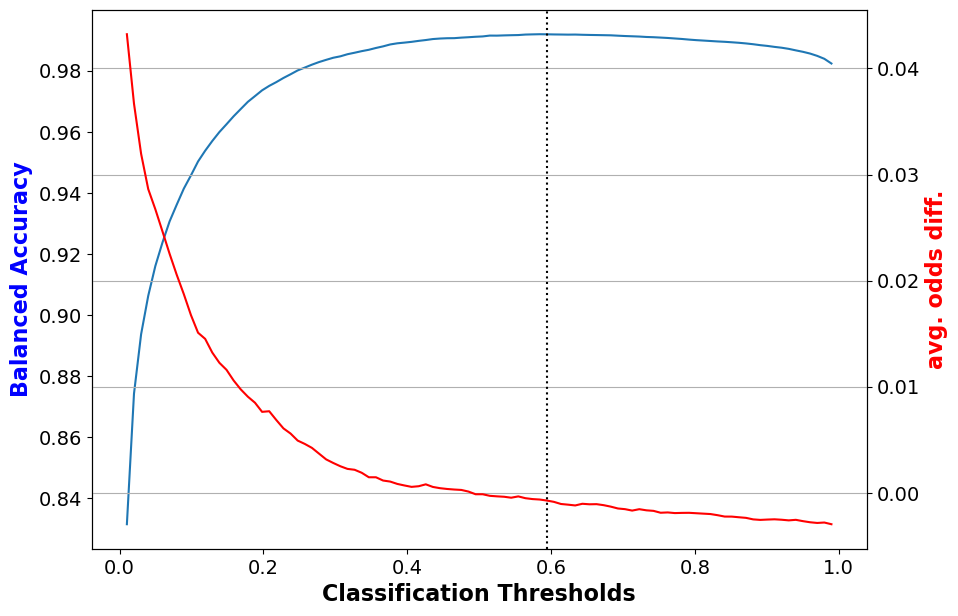

In [25]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig("reject-xg-aodds-orig-nogen")

plt.show()

### Predictions from Transformed Test Set

In [26]:
# Metrics for the transformed test set
dataset_transf_test_pred = ROC.predict(dataset_orig_test_pred)

display(Markdown("#### Test set"))
display(Markdown("##### Transformed predictions - With fairness constraints"))
metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                unprivileged_groups, privileged_groups)

#### Test set

##### Transformed predictions - With fairness constraints

Balanced accuracy = 0.9919
Statistical parity difference = 0.0490
Disparate impact = 1.0684
Average odds difference = -0.0001
Equal opportunity difference = -0.0027
Theil index = 0.0092


In [27]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []
spd_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])
    spd_diff_arr_transf.append(metric_test_bef["Statistical parity difference"])

#### Predictions from transformed testing data

Classification threshold used = 0.5940


 62%|██████▏   | 62/100 [00:04<00:02, 14.73it/s]

Balanced accuracy = 0.9919
Statistical parity difference = 0.0483
Disparate impact = 1.0675
Average odds difference = -0.0007
Equal opportunity difference = -0.0034
Theil index = 0.0095


100%|██████████| 100/100 [00:06<00:00, 14.70it/s]


In [28]:
f1, auc = accuracy_scores(dataset_orig_test.labels, dataset_transf_test_pred, dataset_transf_test_pred.scores, ROC.classification_threshold)

F1 Score: 0.9934
ROC AUC Score: 0.9995


In [29]:
bias_summary_metrics(gender_col, dataset_transf_test_pred.labels)

target: 0         1.0
1         0.0
2         1.0
3         1.0
4         1.0
         ... 
177220    0.0
177221    0.0
177222    1.0
177223    1.0
177224    1.0
Length: 177225, dtype: float64
Chi-Square Statistic: 411.46091752396467
P-value: 1.7624776169240157e-91
There is a significant association between gender and loan approval.
Z-statistic: 20.290106492543153
P-value: 1.572542e-91
There is a significant difference in loan approval rates between men and women.
men total: 115493
women total: 61732
male approval rate: 0.7444347276458313
female approval rate: 0.6994589515972267


### Graph Transformed Test Set

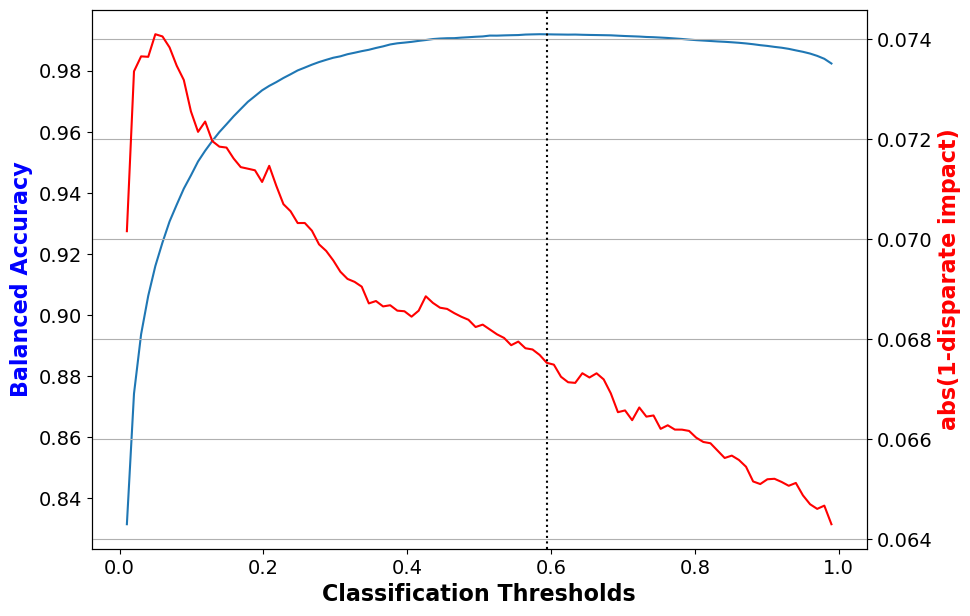

In [30]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig("reject-xg-di-transf-nogen")

plt.show()

```abs(1-disparate impact)``` must be small (close to 0) for classifier predictions to be fair.

For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case.
This implies fairness.

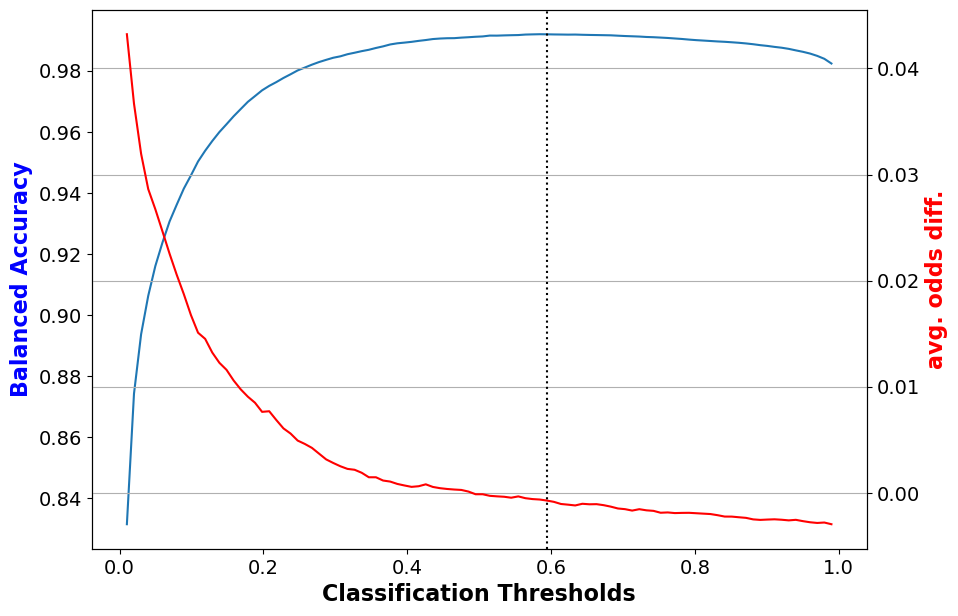

In [31]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig("reject-xg-aodds-transf-nogen")

plt.show()